In [1]:
# Importieren von Bibliotheken
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

import numpy as np
from matplotlib import pyplot as plt

In [2]:
########################################### Funktionen ############################################################################################

def kinetic (circuit, phi):     # Gates zur Simulation der Zeitentwicklung durch H_0
    n = circuit.num_qubits - 1      # Anzahl der Qubits, die in der Simulation genutzt werden

    for i in range(n):
        circuit.p(-phi*2**(i+1),i+1)
        for j in range(i+1,n):
            circuit.cx(j+1,0)
            circuit.cx(i+1,0)
            circuit.p(-phi*2**(i+j+1),0)
            circuit.cx(i+1,0)
            circuit.cx(j+1,0)

    return circuit

def timeEv (circuit, q, phi, iterations):      # Zeitentwicklung
    n = circuit.num_qubits - 1      # Anzahl der Qubits, die in der Simulation genutzt werden
    for i in range(iterations):
        circuit.append(QFT(n), q[1:])
        kinetic(circuit=circuit, phi=phi)
        circuit.append(QFT(n, inverse=True), q[1:])

    return circuit

In [8]:
########################################### Startparameter ########################################################################################

n = 5   # Anzahl Qubits
N = 2**n    # Anzahl Gitterpunkte

phi = 0.005
phi = phi/4     # Phasenfaktor

########################################### Simulation ############################################################################################

q = QuantumRegister(n+1)    # Erzeugen eines Quantenregisters mit zusätzlichem ancilla-Qubit
c = ClassicalRegister(n)    # Erzeugen eines klassichen Registers, in dem die gemessenen Zustände gespeichert werden
circuit = QuantumCircuit(q,c)   # Erstellen eines circuits

# Initialisierung des Anfangszustandes
circuit.initialize([0,1],q[5])


simulator = Aer.get_backend('qasm_simulator')   # Festlegen des Simulators, der genutzt werden soll

timeev = []     # Array, in dem die Zwischenschritte gespeichert werden

# Speichern der Anfangsverteilung
temp = circuit.copy()       # temporärer circuit, dessen Endzustand gemessen wird, um Zustandsfunktion von circuit nicht durch Messung zu kollabieren
for j in range(1,n+1):
    temp.measure(j,j-1)
counts = simulator.run(transpile(temp, simulator), shots=5000).result().get_counts()
timeev.append(counts)

# Zeitentwicklung und Messen der Häufigkeitsverteilungen
it = 5
rg = 8      # Anzahl der Durchläufe mit it Iterationen, pro Durchlauf wird die Häufigkeitsverteilung gespeichert

for i in range (rg):
    timeEv(circuit=circuit, q=q, phi=phi, iterations=it)
    temp = circuit.copy()
    for j in range(1,n+1):
        temp.measure(j,j-1)
    counts = simulator.run(transpile(temp, simulator), shots=5000).result().get_counts()
    timeev.append(counts)

In [9]:
########################################### Plots ################################################################################################

# Modifikation, damit im Histogramm auch die Zustände ohne Einträge angezeigt werden
for i in range(N):
  bin = format(i, '0'+str(n)+'b')

  for j in range(len(timeev)):
    if bin not in timeev[j].keys():
      timeev[j][bin] = 0

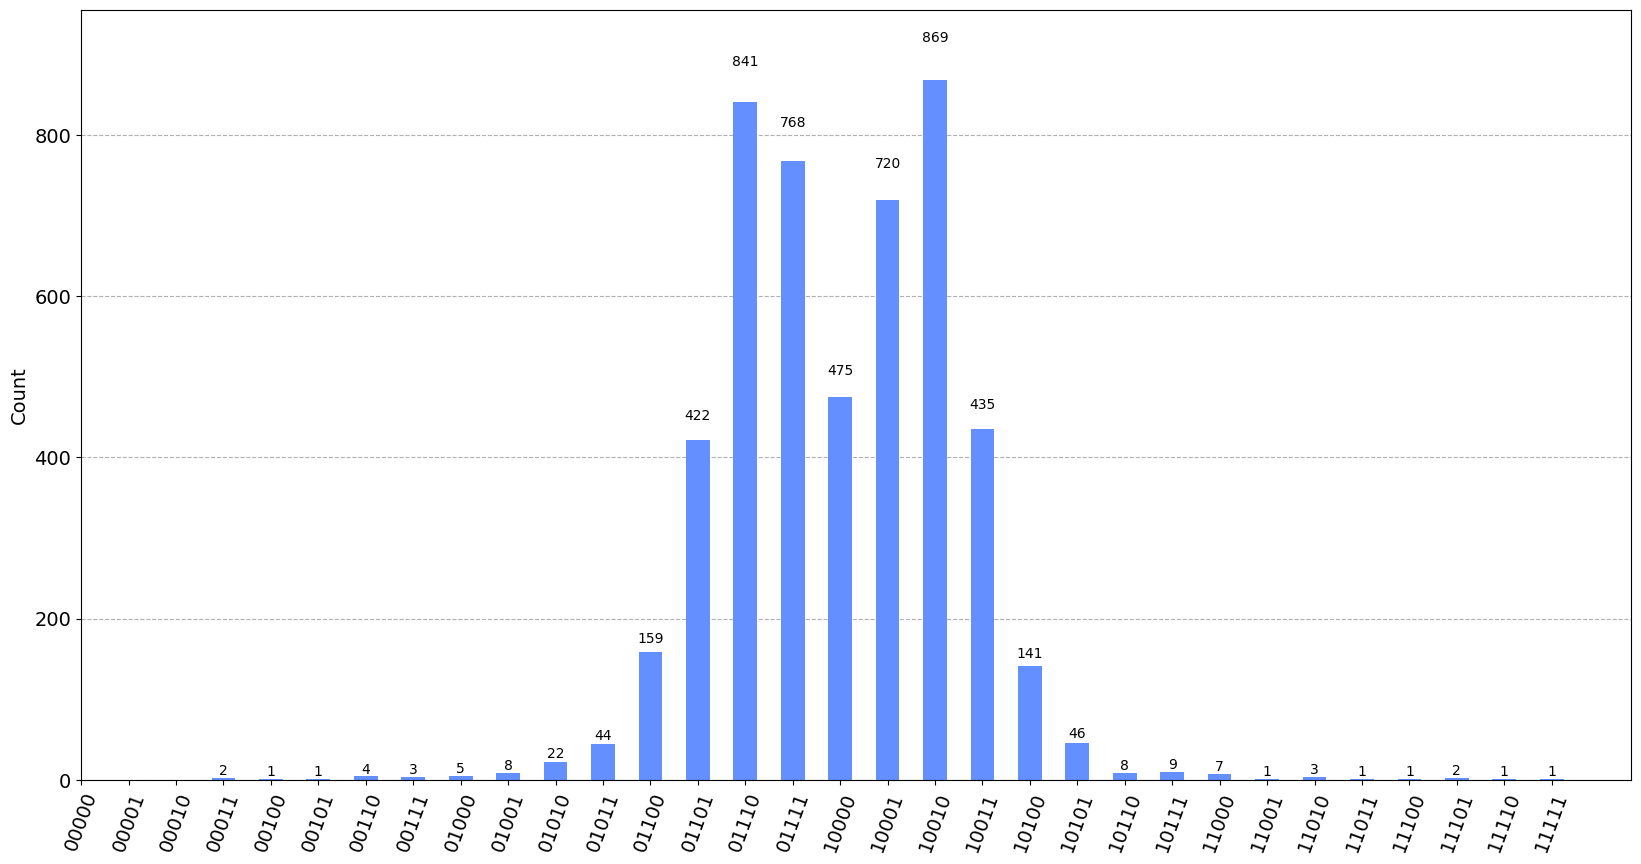

In [10]:
plot_histogram(timeev[2], figsize=[20,10])    # Anzeigen der Histogramme
#plot_histogram(timeev[0], figsize = [20,10], filename='timeev_bit1.jpg')   # Speichern der Histogramme 